# General properties and calculations
For Argon propellant

In [32]:
# Base imports
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from CoolProp.CoolProp import PropsSI

# Custom packages
import IdealThrust as it
import saha

matplotlib.matplotlib_fname()

'/home/emmanuel/.config/matplotlib/matplotlibrc'

In [33]:
## Define and print some useful values
R_UNIV = 8.31446261815324  # J mol^-1 K^-1, Universal gas constant

workingFluid = 'Air'
standard_pressure = 101.3e3  # Pa, atmospheric pressure
standard_temperature = 273.15  # K, standard temperature (0C)
room_temperature = 300  # K, ambient temperature

gamma = PropsSI('isentropic_expansion_coefficient', 
    'P', standard_pressure, 
    'T', room_temperature, 
    workingFluid)
GAMMA = it.getGAMMA(gamma)
molarMass = PropsSI('M', workingFluid)

Rg = R_UNIV/molarMass

print('gamma =', gamma)
print('GAMMA =', GAMMA)
print('M =', molarMass, 'kg/mol')
print('Rg =', Rg, 'J/kg-K')

gamma = 1.4012562616241042
GAMMA = 0.6849435395521697
M = 0.02896546 kg/mol
Rg = 287.047490982475 J/kg-K


In [34]:
## Define some inputs
min_pc = 3e5  # Pa
max_pc = 20e5  # Pa
chamber_pressures = np.linspace(min_pc, max_pc)

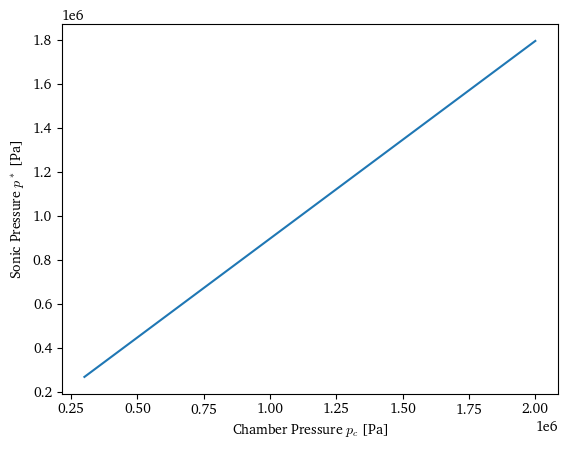

In [35]:
## Compute sonic conditions
sonic_pressures = chamber_pressures*(2/(gamma+1))**(gamma/(gamma+1))
plt.plot(chamber_pressures, sonic_pressures)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Sonic Pressure $p^*$ [Pa]')
plt.show()

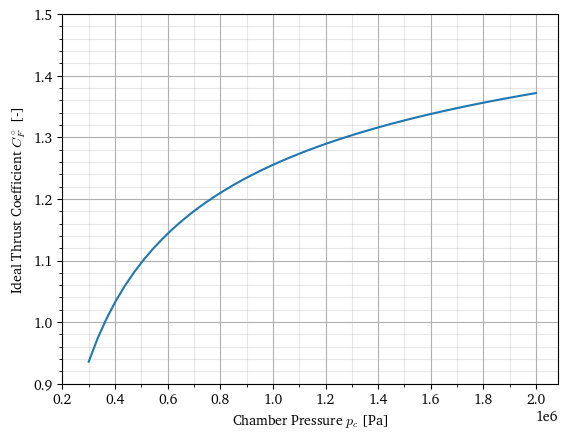

In [36]:
## Computing ideal expansion thrust factor
cf_ideal = it.cf_ideal(gamma, standard_pressure, chamber_pressures)

# Plotting
plt.plot(chamber_pressures, cf_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel('Ideal Thrust Coefficient $C_F^\circ$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/5), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)

plt.show()

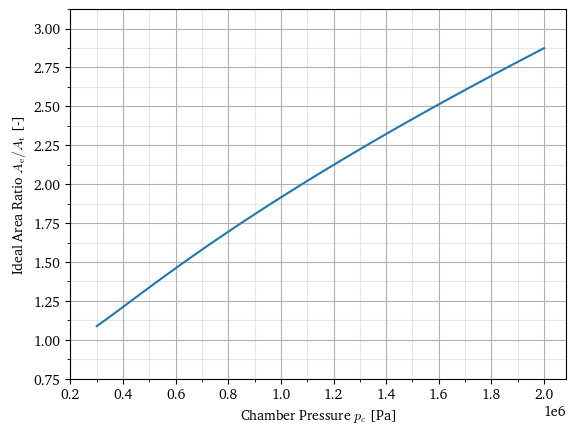

In [37]:
## Computing associated nozzle geometry
Aratio_ideal = it.Aratio_ideal(gamma, standard_pressure, chamber_pressures)

plt.plot(chamber_pressures, Aratio_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Ideal Area Ratio $A_\mathrm{e}/A_\mathrm{t}$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/2), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)

plt.show()